In [1]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import torch
import gc
gc.enable()

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt

# The presented script is designed for running on Kaggle.

In [3]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["figure.dpi"] = 300
plt.rcParams["grid.linewidth"] = 1

In [4]:
def classifier(input : pd.DataFrame):
    return np.round(np.clip(input.to_numpy(), 1, 7))

In [5]:
FOLDER = "/kaggle/input/the-future-crop-challenge"
BATCH_SIZE = 128
TS_LENGTH = 240

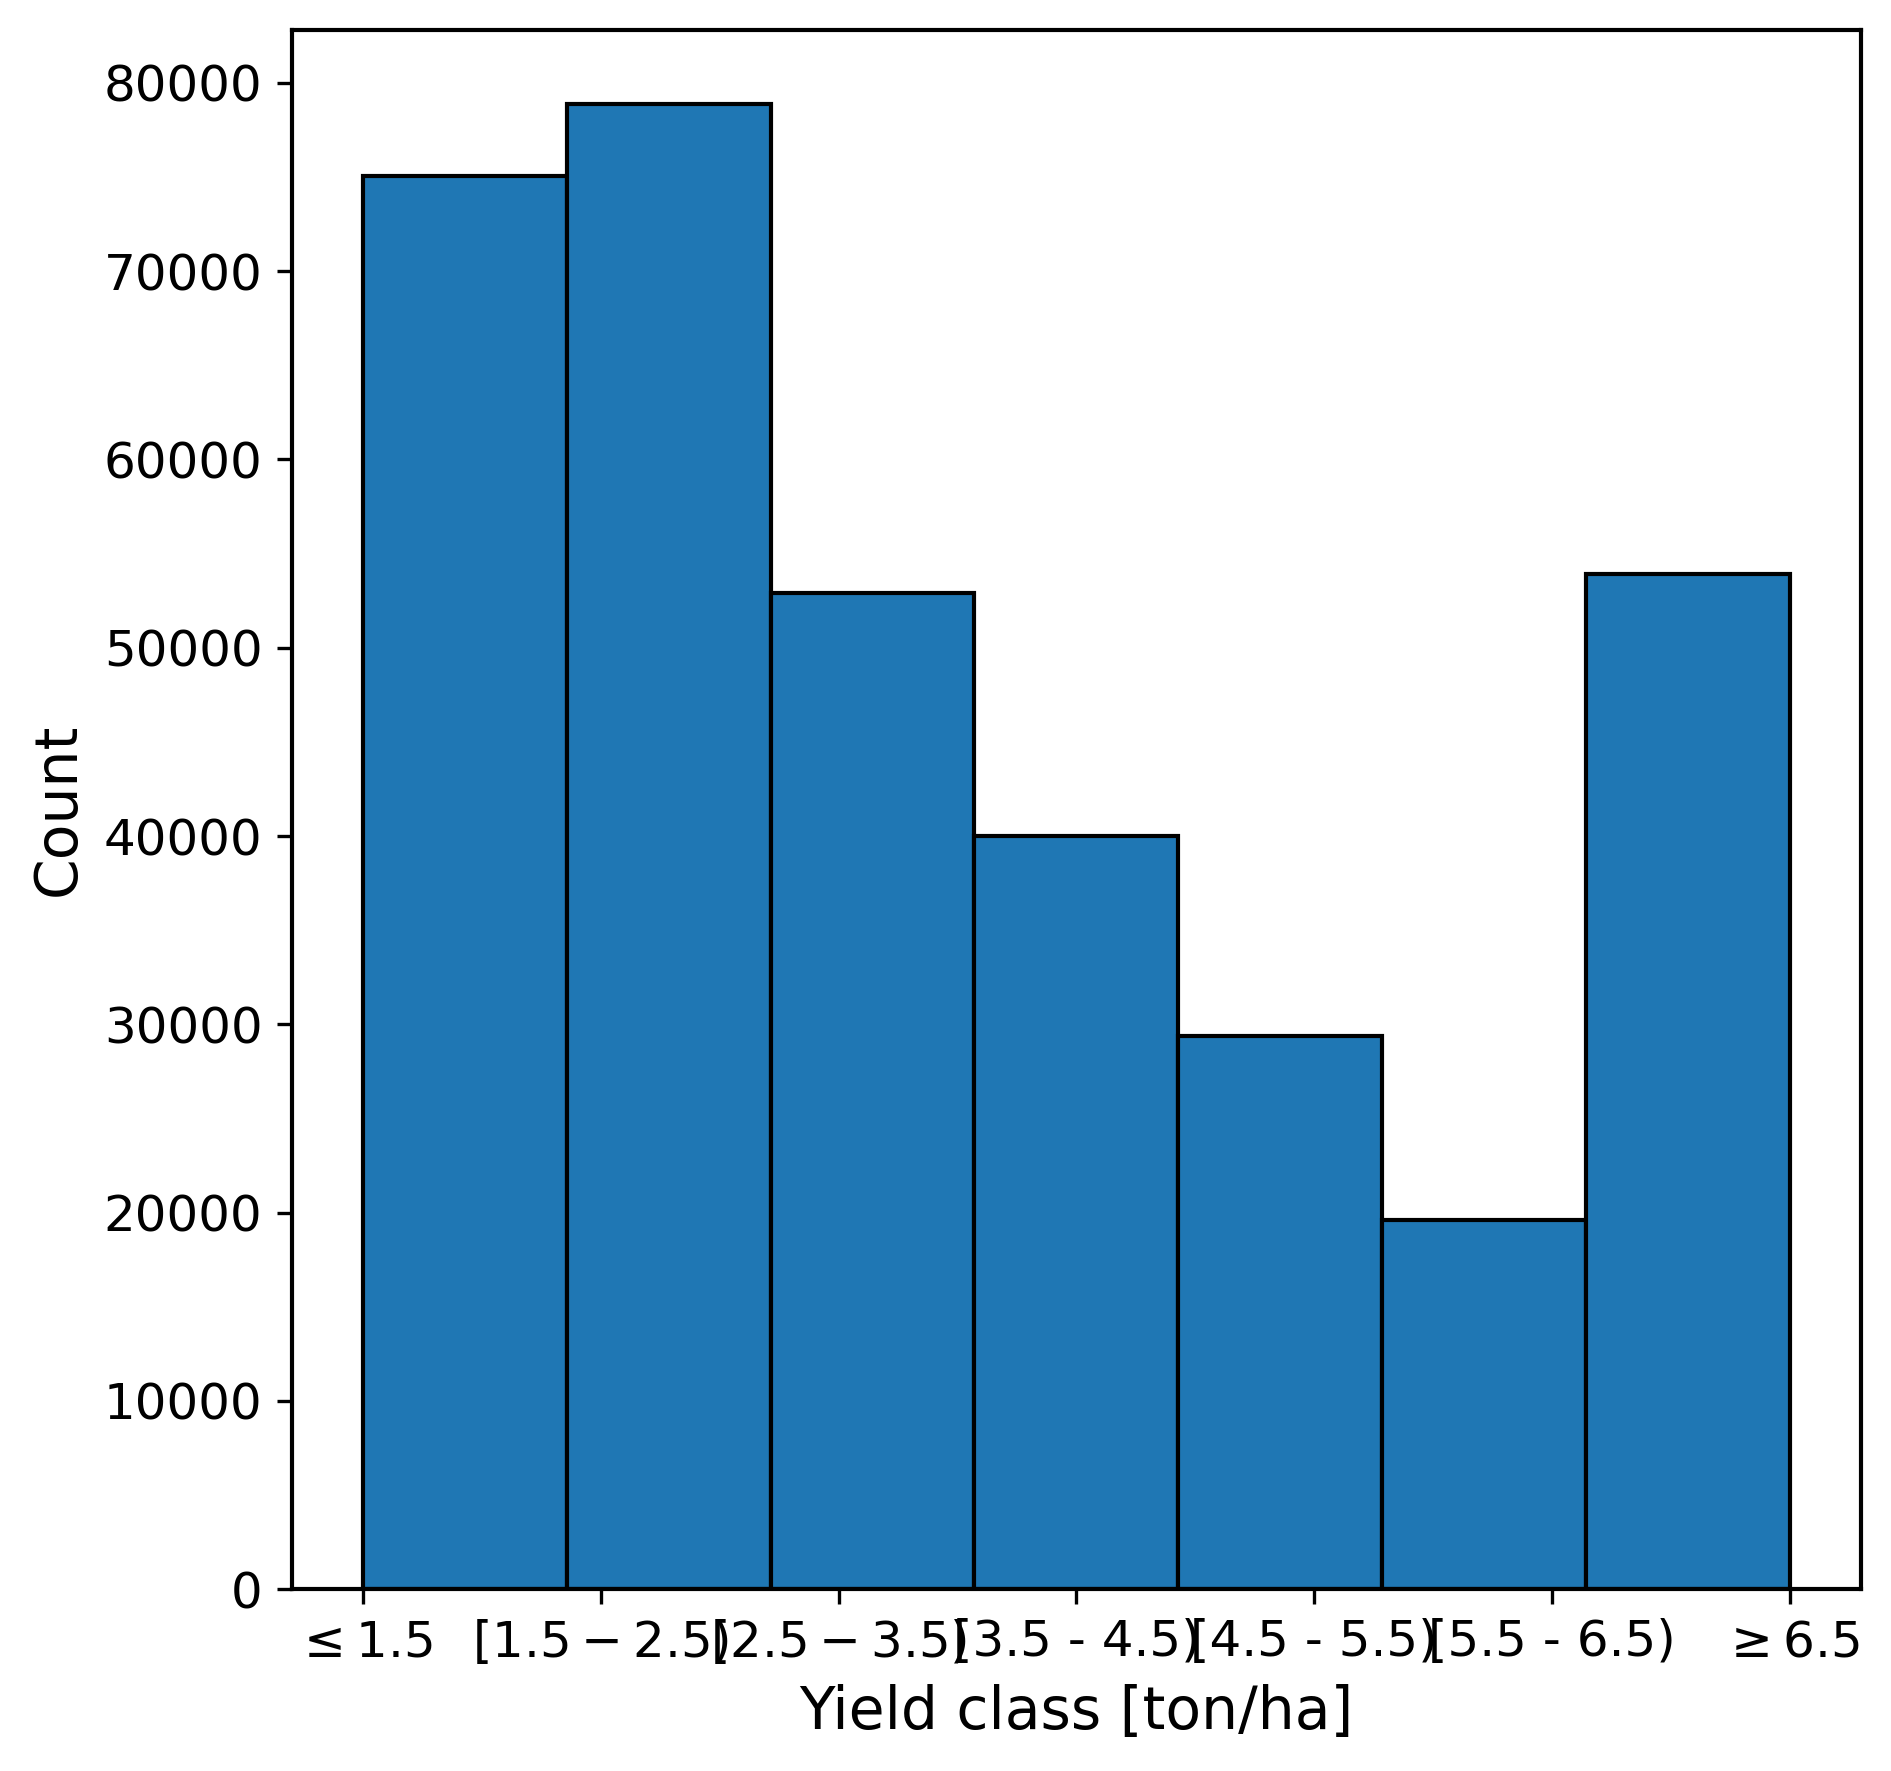

In [6]:
regression = pq.read_table('/kaggle/input/the-future-crop-challenge/train_solutions_maize.parquet').to_pandas()
regression.loc[:, 'class'] = classifier(regression)
regression.to_csv('answers.csv')

fig = plt.figure(figsize=(6.75, 6.75))
plt.hist(regression['class'], bins=7, align='mid', edgecolor='black')
plt.ylabel('Count')
plt.xlabel('Yield class [ton/ha]')
plt.xticks([i for i in range(1, 8)],
           ['$\leq 1.5$', '$[1.5 - 2.5)$', '$[2.5 - 3.5)$', '[3.5 - 4.5)', 
            '[4.5 - 5.5)', '[5.5 - 6.5)', '$\geq6.5$'])
plt.show()
fig.savefig('./future-crop-classes.pdf', dpi=600)

In [ ]:
def conversion(folder : str, split : str, 
               ts_length = 240, batch_size = 128):
    assert split in ['train', 'test', 'val']
    files = os.listdir(folder)
    # Prepare folder for output
    if not os.path.exists(f'./{split}-output/'): os.mkdir(f'./{split}-output/')

    if split == 'val' : folder_split = 'train'
    else: folder_split = split
    selection = [file for file in files if f'maize_{folder_split}' in file]
    weather_features = sorted([file[0:file.find('maize')-1] for file in selection])
    weather_features.pop(2) # remove soil features
    soil = pq.read_table(os.path.join(folder, f"soil_co2_maize_{folder_split}.parquet")).to_pandas()
    # if split == 'train':
    #     conversion = soil[soil['real_year'] <= 2000]
    # elif split == 'val':
    #     conversion = soil[soil['real_year'] > 2001]
    # elif split == 'test':
    #     conversion = soil
    conversion = soil
    conversion = conversion.loc[:, ['lat', 'lon', 'real_year']]
    conversion.to_csv(f"./{split}-output/{split}-conversion.csv")
    soil = soil.drop(['lat', 'lon', 'real_year', 'year', 'crop'], axis=1)
    soil_features = len(soil.columns)
    timeseries = [str(i) for i in range(ts_length)]

    tables = []
    for feature in tqdm(weather_features, desc="Reading"):
        table = pq.read_table(os.path.join(folder, f"{feature}_maize_{folder_split}.parquet")).to_pandas()
        table = table.loc[:,timeseries]
        assert table.loc[:,:].to_numpy().sum() != np.nan
        tables.append(table)

    ids = conversion.index
    total_features = len(weather_features) + len(soil.columns)
    dataset = np.empty(shape=(len(ids), ts_length, total_features))

    soil_ts = np.ones(shape=ts_length)
    for idx, np_idx in zip(tqdm(ids, desc="Processing"), range(len(ids))):
        matrix = np.empty(shape=(ts_length, len(weather_features)))
        for j in range(len(weather_features)):
            matrix[:,j] = tables[j].loc[idx,:].to_numpy()
            
        matrix = np.concatenate([matrix, np.outer(soil_ts, soil.loc[idx, :].to_numpy())], axis=1)
        assert matrix.sum() != np.nan
        dataset[np_idx, :, :] = matrix 

    if split == 'train' or 'val':
        answers = pq.read_table('/kaggle/input/the-future-crop-challenge/train_solutions_maize.parquet').to_pandas()
        answers.loc[:,:] = classifier(answers)
    else:
        answers = pd.DataFrame(index=ids, columns='yield', data=0)
    answers = answers.to_numpy()

    if split == 'val': name = 'test'
    else: name = split

    batch_number = 0
    for i in tqdm(range(0, len(ids), batch_size), desc="Saving"):
        file = {}
        file['samples'] = dataset[i:min(i+batch_size, len(ids)),:,:]
        file['labels'] = answers[i:min(i+batch_size, len(ids))]
        torch.save(file, os.path.join(f"./{split}-output/", f"{name}_{batch_number}.pt"))
        batch_number += 1

In [ ]:
conversion(folder=FOLDER, split='train', batch_size=BATCH_SIZE, ts_length=TS_LENGTH)
gc.collect()

In [ ]:
!zip -r train-output.zip ./train-output -q
!rm -rf ./train-output

In [ ]:
# conversion(folder=FOLDER, split='val', batch_size=BATCH_SIZE, ts_length=TS_LENGTH)
# gc.collect()

In [ ]:
# !zip -r val-output.zip ./val-output -q
# !rm -rf ./val-output

In [ ]:
# conversion(folder=FOLDER, split='test', batch_size=BATCH_SIZE, ts_length=TS_LENGTH)
# gc.collect()

In [ ]:
# !zip -r test-output.zip ./test-output -q
# !rm -rf ./test-output